# Generate Audio

## Util methods

In [1]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
from pydub import AudioSegment
import functools

def signal(a, f, t, sr=44_100):
    return a * np.sin(2 * np.pi * f * (t / sr))

def get_sine(a, f, d, sr=44_100):
    ns = int(d * (sr / 1000.0))
    
    t = np.arange(0, ns)
    y = signal(a, f, t, sr).astype(np.float32)

    return pd.Series(y, t)

def overlay(a, f, d, sr=44_100):
    sines = [get_sine(_a, _f, d, sr) for _a, _f in zip(a, f)]
    s = functools.reduce(lambda a, b: a + b, sines)
    return s

def save(a, f, d, sr=44_100):
    s = get_sine(a=a, f=f, d=d, sr=sr)
    path = f'./_temp/test-amp-{a:03}-freq-{f:03}-{sr:05}.wav'
    wavfile.write(path, sr, s.values)
    
    return path

## Vary amplitude

In [2]:
AudioSegment.from_wav(save(a=1, f=100, d=5_000))

In [3]:
AudioSegment.from_wav(save(a=2, f=100, d=5_000))

In [4]:
AudioSegment.from_wav(save(a=10, f=100, d=5_000))

## Vary frequency

In [5]:
AudioSegment.from_wav(save(a=1, f=500, d=5_000))

In [6]:
AudioSegment.from_wav(save(a=1, f=1_000, d=5_000))

## Overlay waves

In [7]:
d = 60_000

s1 = get_sine(a=1, f=100, d=d)
s2 = get_sine(a=2, f=100, d=d)
s3 = get_sine(a=10, f=100, d=d)

sF = s1 + s2 + s3

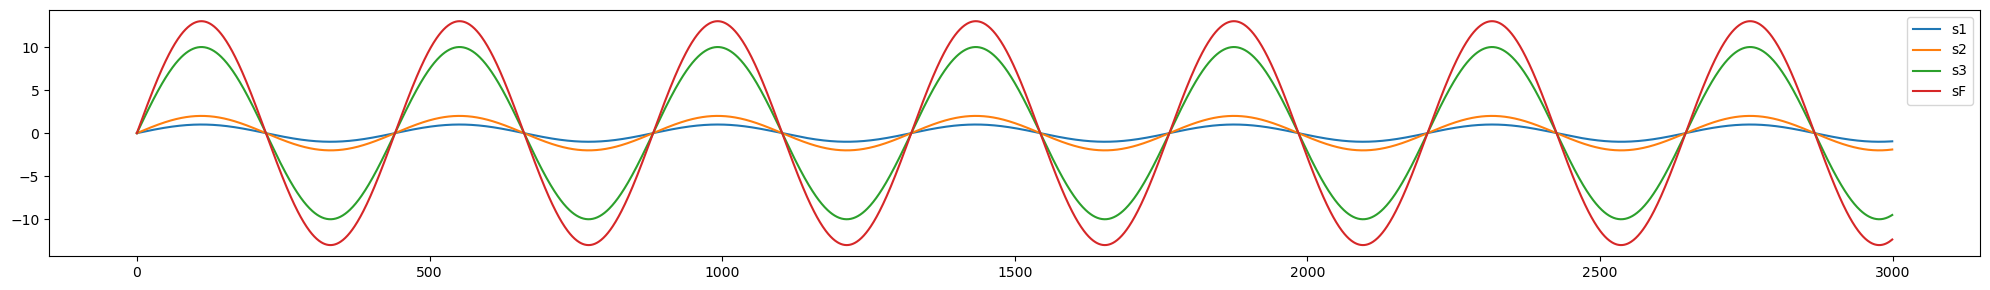

In [8]:
import matplotlib.pyplot as plt

idx_max = 3_000

fig, ax = plt.subplots(figsize=(20, 3))

s1[:idx_max].plot(kind='line', ax=ax, label='s1')
s2[:idx_max].plot(kind='line', ax=ax, label='s2')
s3[:idx_max].plot(kind='line', ax=ax, label='s3')
sF[:idx_max].plot(kind='line', ax=ax, label='sF')

ax.legend()

fig.tight_layout()

In [9]:
wavfile.write('./_temp/overlay.wav', 44_100, sF.values)

In [10]:
song = AudioSegment.from_wav('./_temp/overlay.wav')

In [11]:
song.export(
    './_temp/overlay.mp3', 
    format='mp3', 
    bitrate='192k',
    tags={
        'artist': 'jee_force', 
        'album': 'One-Off Coder', 
        'comments': 'Generative AI'
    })

<_io.BufferedRandom name='./_temp/overlay.mp3'>

In [12]:
song

In [13]:
s = overlay([0.1, 2, 0.5, 1.5, 0.5], [10, 50, 600, 700, 1_000], 10_000)
wavfile.write('./_temp/overlay.wav', 44_100, s.values)
AudioSegment.from_wav('./_temp/overlay.wav')